In [1]:
import torch
import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import DataLoader , random_split  # Gives easier dataset managment by creating mini batches etc.
import matplotlib.pyplot as plt

### CNN Model 
Archecture: 
  
  Conv2d(kernel=8) ---> Conv2d(kernel=4) ---> Linear(30 unit) ---> Linear(10 unit)

In [2]:
# Simple CNN
class CNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(CNN, self).__init__()
        self.batch1 = nn.BatchNorm2d(1)
        self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=12,kernel_size=(8, 8),stride=(1, 1),padding=(1, 1),bias=False)
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.batch2 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(in_channels=12,out_channels=12,kernel_size=(4, 4),stride=(1, 1),padding=(1, 1),bias=False)
        self.fc1 = nn.Linear(12*5*5, 30)
        self.fc2 = nn.Linear(30, num_classes)
        self.initialize_weights()                     #  Glorot initialization.

    def forward(self, x):
        x = self.batch1(x)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.batch2(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def initialize_weights(self):         # Glorot initialization.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)

                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
in_channels = 1
num_classes = 10
learning_rate = 0.05
batch_size = 10
num_epochs = 20

# Loading Data

In [4]:
# Load Data
train_dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root="dataset/", train=False, transform=transforms.ToTensor(), download=True)

train, valid = random_split(train_dataset,[50000,10000]) #Dividing into train and validation
train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw




Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw




Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw




Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [8]:
# Initialize network
model = CNN(in_channels=in_channels, num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) #learning rate scheduler that adjust the learning rate by 10% every 10 epochs

In [9]:
def test(loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in loader:
      data = data.to(device)
      target = target.to(device)
      output = model(data)
      test_loss += criterion(output, target).item()
      # pred = output.data.max(1, keepdim=True)[1]
      pred = torch.argmax(output, dim=1)
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(loader.dataset)
  test_losses.append(test_loss)
  accuracy = 100 * correct / len(loader.dataset)
  model.train()
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(loader.dataset),100. * correct / len(loader.dataset)))
  return accuracy

In [10]:
train_losses = []
train_counter = []
test_losses = []
accuracy = []
test_counter = [i*len(test_loader.dataset) for i in range(num_epochs + 1)]

In [11]:
# Train Network
accuracy.append(test(valid_loader))
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm(model.parameters(),max_norm=1)

        # gradient descent or adam step
        optimizer.step()
        

        if batch_idx % 10 == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
          train_losses.append(loss.item())
          train_counter.append((batch_idx*10) + ((epoch-1)*len(train_loader.dataset)))

    scheduler.step()
    accuracy.append(test(valid_loader))


Test set: Avg. loss: 0.2305, Accuracy: 1177/10000 (12%)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.894757
Train Epoch: 0 [100/50000 (0%)]	Loss: 1.866454
Train Epoch: 0 [200/50000 (0%)]	Loss: 1.132602


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  app.launch_new_instance()


Streaming output truncated to the last 5000 lines.
Train Epoch: 10 [3000/50000 (6%)]	Loss: 0.000032
Train Epoch: 10 [3100/50000 (6%)]	Loss: 0.000251
Train Epoch: 10 [3200/50000 (6%)]	Loss: 0.000000
Train Epoch: 10 [3300/50000 (7%)]	Loss: 0.000000
Train Epoch: 10 [3400/50000 (7%)]	Loss: 0.000001
Train Epoch: 10 [3500/50000 (7%)]	Loss: 0.000000
Train Epoch: 10 [3600/50000 (7%)]	Loss: 0.000021
Train Epoch: 10 [3700/50000 (7%)]	Loss: 0.000038
Train Epoch: 10 [3800/50000 (8%)]	Loss: 0.000000
Train Epoch: 10 [3900/50000 (8%)]	Loss: 0.000003
Train Epoch: 10 [4000/50000 (8%)]	Loss: 0.000032
Train Epoch: 10 [4100/50000 (8%)]	Loss: 0.000001
Train Epoch: 10 [4200/50000 (8%)]	Loss: 0.000005
Train Epoch: 10 [4300/50000 (9%)]	Loss: 0.000004
Train Epoch: 10 [4400/50000 (9%)]	Loss: 0.000001
Train Epoch: 10 [4500/50000 (9%)]	Loss: 0.000252
Train Epoch: 10 [4600/50000 (9%)]	Loss: 0.000013
Train Epoch: 10 [4700/50000 (9%)]	Loss: 0.000001
Train Epoch: 10 [4800/50000 (10%)]	Loss: 0.000000
Train Epoch: 10 [

# Accuracy Graph

Text(0.5, 0, 'Epoch')

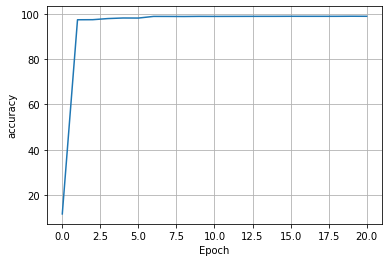

In [13]:
plt.plot(accuracy)
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('Epoch')

# Learning Curve

Text(0, 0.5, 'negative log likelihood loss')

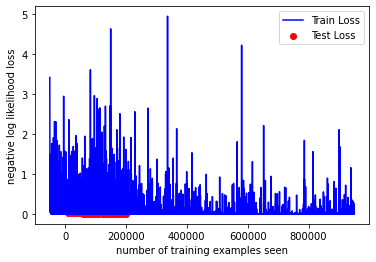

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

# Accuracy on Test Set

In [ ]:
test(test_loader)


Test set: Avg. loss: 0.0051, Accuracy: 9909/10000 (99%)



In the learning curve the loss is near to zero and 1 which means it may be overfitting the data but after finding the acccuracy on test set it is cleared that model is perfectly fitted on data. 

In [ ]:
torch.set_printoptions(sci_mode=False)

# Confusion Matrix

Text(0.5, 69.0, 'Predicted label')

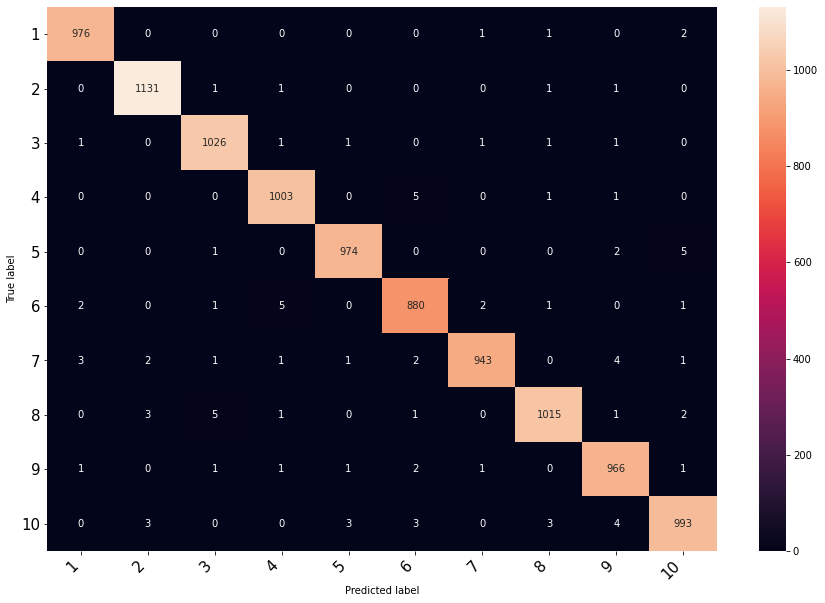

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
nb_classes = 10
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(15,10))

class_names = list(range(1,11))
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')